# Carga de librerias

In [1]:
# Handling data
import pandas as pd
import numpy as np
import json

# Visualitation
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# write model
import joblib
import gzip



# Objetivo
En el presen jupyternotebook se buscara explorar y crear un modelo que sea capaz identificar a los usuarios que no realizaran un pago o se atrasaran en un periodo de 28 días

Este jupyternotebook es una parte del proyecto que se encuentra aquí https://github.com/alonmar/users_classification_default




# Importación de datos

In [2]:
data_raw = pd.read_csv('raw_data/Train Data.csv')
data_raw.columns

Index(['ID', 'label', 'edad', 'montoSolicitado', 'montoOtorgado', 'genero',
       'quincenal', 'dependientesEconomicos', 'nivelEstudio', 'fico',
       'ingresosMensuales', 'gastosMensuales', 'emailScore', 'browser',
       'NUMTDC_AV'],
      dtype='object')

# EDA

In [3]:
data_raw.shape

(1000, 15)

In [4]:
data_raw.dtypes

ID                          int64
label                       int64
edad                      float64
montoSolicitado           float64
montoOtorgado             float64
genero                     object
quincenal                   int64
dependientesEconomicos      int64
nivelEstudio               object
fico                        int64
ingresosMensuales         float64
gastosMensuales             int64
emailScore                float64
browser                    object
NUMTDC_AV                 float64
dtype: object

In [5]:
# Veamos los primeros 5 datos
data_raw.head()

,ID,label,edad,montoSolicitado,montoOtorgado,genero,quincenal,dependientesEconomicos,nivelEstudio,fico,ingresosMensuales,gastosMensuales,emailScore,browser,NUMTDC_AV
0,1,0,38.0,11890.0,11890.0,Hombre,0,1,Universidad,561,7000.0,7000,0.0,CHROME9,1.0
1,2,0,26.0,3700.0,3700.0,Hombre,1,0,Preparatoria,649,8000.0,3000,0.0,CHROME9,1.0
2,3,0,28.0,13980.0,13980.0,Hombre,0,0,Universidad,575,7500.0,2000,NaN,NaN,3.0
3,4,0,27.0,12016.0,6286.0,Hombre,0,0,Universidad,651,12800.0,4300,1.0,UNKNOWN,NaN
4,5,0,31.0,20000.0,12000.0,Hombre,1,1,Universidad,444,20000.0,12000,1.0,MOBILE_SAFARI,NaN


In [6]:
# Distribución de las variables numericas
data_raw.describe()

,ID,label,edad,montoSolicitado,montoOtorgado,quincenal,dependientesEconomicos,fico,ingresosMensuales,gastosMensuales,emailScore,NUMTDC_AV
count,1000.000000,1000.000000,996.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,873.000000,506.000000
mean,500.500000,0.220000,34.588353,15871.090740,11871.470470,0.156000,0.995000,533.60800,24852.949160,12692.456000,1.882016,2.203557
std,288.819436,0.414454,10.176296,17109.302264,12951.028413,0.363037,1.127939,141.94502,38290.063995,28816.956572,5.325080,1.518228
min,1.000000,0.000000,18.000000,1000.000000,1000.000000,0.000000,0.000000,0.00000,12.000000,2.000000,0.000000,1.000000
25%,250.750000,0.000000,27.000000,5289.500000,4393.750000,0.000000,0.000000,491.00000,10000.000000,4000.000000,0.000000,1.000000
50%,500.500000,0.000000,32.000000,11000.000000,7795.000000,0.000000,1.000000,560.00000,16000.000000,7000.000000,1.000000,2.000000
75%,750.250000,0.000000,40.000000,19000.000000,15000.000000,0.000000,2.000000,618.25000,25000.000000,14000.000000,1.000000,3.000000
max,1000.000000,1.000000,69.000000,150000.000000,100000.000000,1.000000,5.000000,748.00000,900000.000000,750000.000000,80.000000,12.000000


In [7]:
# Distribución de las variables categoricas
data_raw.describe(include=[object])

,genero,nivelEstudio,browser
count,1000,1000,871
unique,2,7,12
top,Hombre,Universidad,CHROME_MOBILE
freq,719,534,437


In [8]:
data_raw['genero'].unique().tolist()

['Hombre', 'Mujer']

In [9]:
data_raw['nivelEstudio'].unique().tolist()
# tenemos un error de typo en 'Maestr√≠a'

['Universidad',
 'Preparatoria',
 'Maestr√≠a',
 'Secundaria',
 'Primaria',
 'Doctorado',
 'Ninguno']

In [10]:
data_raw['browser'].unique().tolist()
# mas a delante manejaremos esos datos faltantes
# observamos que podemos saber si es desde un movil desde donde ocurre la conexión sería interesante ver si existe una correlación

['CHROME9',
 nan,
 'UNKNOWN',
 'MOBILE_SAFARI',
 'CHROME_MOBILE',
 'CHROME8',
 'APPLE_WEB_KIT',
 'FIREFOX8',
 'MOZILLA',
 'FIREFOX_MOBILE',
 'CHROME',
 'SAFARI',
 'EDGE_MOBILE']

El tipo de columnas es consistentes con su contenido

## Limpieza 

In [11]:
# No necesitamos la columna ID
data_clean = data_raw.drop(columns=['ID'])

# Para temas de visualizacion y de cohort cambiaremos modificaremos la clumna 'label'
data_clean['label'] = data_clean['label'].apply(lambda x: 'Moroso' if x == 1 else 'No Moroso')


### Manejo de datos faltantes

In [12]:
# NAs por columna
data_clean.isnull().sum() 

label                       0
edad                        4
montoSolicitado             0
montoOtorgado               0
genero                      0
quincenal                   0
dependientesEconomicos      0
nivelEstudio                0
fico                        0
ingresosMensuales           0
gastosMensuales             0
emailScore                127
browser                   129
NUMTDC_AV                 494
dtype: int64

Text(0.5, 1.0, 'NAs por columna')

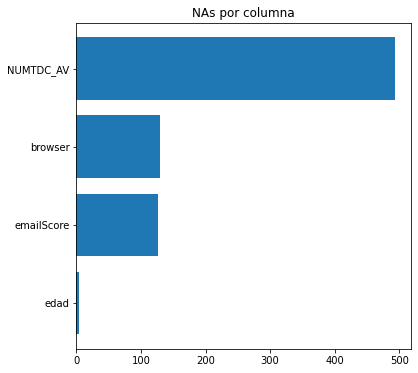

In [13]:
# Create a data frame
df = pd.DataFrame ({
        'column':  data_clean.isna().sum().index,
        'NAs': (data_clean.isna().sum())
}).sort_values(by=['NAs']).query("NAs > 0")

fig, ax = plt.subplots()
fig.set_size_inches(6,6)
ax.barh(y=df.column, width=df.NAs)

# Add title
ax.set_title('NAs por columna')

#### Imputacion de NAs

Son 4 columnas las que presentan NAs:

Para el caso de 'edad' al ser solo 4 datos nulos tomaremos su promedio para imputar 

Para 'emailScore' los datos nulos seran tratados como ceros ya que esto es equivalente a no tener confianza sobre ese email

Para 'browser' utilizaremos la categoria 'UNKNOWN' que ya existe

En el caso de NUMTDC_AV partiremos de algunos supuestos el primero como vemos https://blog.kardmatch.com.mx/cuantas-tarjetas-de-credito-es-recomendable-tener, https://www.bbva.com/es/cuantas-tarjetas-credito-conviene/, las recomendacion es de dos tarejetas de credito y https://www.nerdwallet.com/article/finance/how-many-credit-cards mencionan que en promedio un estadunidense tiene 2.3  tarjetas de credito ( curiosamente muy cercano al 2.2 de nuestros datos) y tomando en cuenta que los habitos tiende a parecerce entre paises la columna NUMTDC_AV la convertiremos en una varible categorica con 3 categorias, 'UNKNOWN', '3 o menos tarjetas de credito' 'mas de 3 tarjetas' se selecciona 3 tarjetas y no 2, ya que con las nuevas tarjetas 'sin anualidad' existen incentivos para adquirir una extra

In [14]:
# Estas imputaciones se pueden realizar dentro del pipline de sklearn sin embargo para tener un mejor control y dado 
# que son pocas las columnas se tratara una a una

def clean_data(data):
    
    # corregimos "Maestr√≠a" a "Maestria"
    data['nivelEstudio'] = data_clean.nivelEstudio.replace("Maestr√≠a", "Maestria")

    # emailScore
    data['emailScore'] = data['emailScore'].fillna(0)

    # browser
    data['browser'] = data['browser'].fillna("UNKNOWN")

    # NUMTDC_AV
    cond_list = [data['NUMTDC_AV']  <= 3, data['NUMTDC_AV']  > 3]
    choice_list = ['3 o menos TC', 'Mas de 3 TC']

    data['NUMTDC_AV'] = np.select(cond_list, choice_list, default='UNKNOWN')

    return data


In [15]:
data_clean = clean_data(data_clean)

In [16]:
data_clean.describe()
# NUMTDC_AV pasa a ser categorica

,edad,montoSolicitado,montoOtorgado,quincenal,dependientesEconomicos,fico,ingresosMensuales,gastosMensuales,emailScore
count,996.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,34.588353,15871.090740,11871.470470,0.156000,0.995000,533.60800,24852.949160,12692.456000,1.643000
std,10.176296,17109.302264,12951.028413,0.363037,1.127939,141.94502,38290.063995,28816.956572,5.014449
min,18.000000,1000.000000,1000.000000,0.000000,0.000000,0.00000,12.000000,2.000000,0.000000
25%,27.000000,5289.500000,4393.750000,0.000000,0.000000,491.00000,10000.000000,4000.000000,0.000000
50%,32.000000,11000.000000,7795.000000,0.000000,1.000000,560.00000,16000.000000,7000.000000,1.000000
75%,40.000000,19000.000000,15000.000000,0.000000,2.000000,618.25000,25000.000000,14000.000000,1.000000
max,69.000000,150000.000000,100000.000000,1.000000,5.000000,748.00000,900000.000000,750000.000000,80.000000


In [17]:
data_clean.describe(include=[object])

,label,genero,nivelEstudio,browser,NUMTDC_AV
count,1000,1000,1000,1000,1000
unique,2,2,7,12,3
top,No Moroso,Hombre,Universidad,CHROME_MOBILE,UNKNOWN
freq,780,719,534,437,494


Veamos graficamente las variables categoricas

In [18]:
# Funciones auxiliares para graficar variables categoricas
def categorical_bar_plot(column):
    sns.set(style="darkgrid")
    df = data_clean[column].value_counts()/data_clean[column].value_counts().sum()*100
    ax = df.sort_values().plot(kind='barh', title = column.upper())
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())

def box_plot(column):
    plt.figure(figsize=(6, 10))
    sns.boxplot(x=data_clean["label"], y=data_clean[column], showfliers = False)
    plt.show()

def plot_ratio_by_column_and_label(colum):
    """Help to plot categorical columns"""
    group_by_label_and_column = (
    data_clean.groupby(['label'])[colum]
    .value_counts()
    .reset_index(name='count')
    )

    group_by_label_and_column['Porcentaje'] = (
        group_by_label_and_column
        .groupby('label')['count']
        .apply(lambda x: x/x.sum()*100)
    )

    sns.set(style="darkgrid")
    g = sns.FacetGrid(group_by_label_and_column, col="label", height=6, col_wrap=1, hue="label", aspect=.85)
    g.map(sns.barplot, "Porcentaje", colum)

    plt.show()


Existe un desvalance en el tamaño de nuestras clases es importante tener en cuenta esto

In [19]:
data_clean['label'].value_counts()

No Moroso    780
Moroso       220
Name: label, dtype: int64

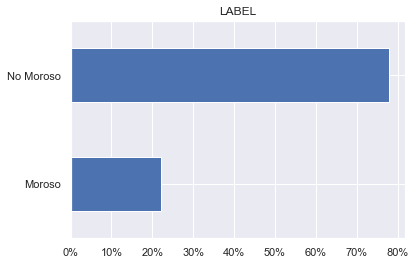

In [20]:
categorical_bar_plot('label')

Estamos frente a un problema de clasificacion desvalanceado ya que el tipo de usuario "Moroso" (clase positiva)
mantiene una relación de  0.282 respecto a "No Moroso" (clase negativa)

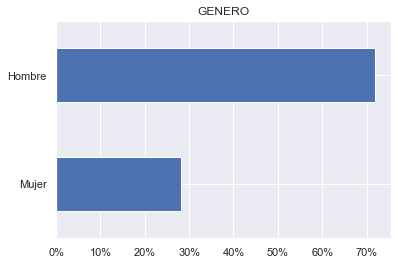

In [21]:
categorical_bar_plot('genero')

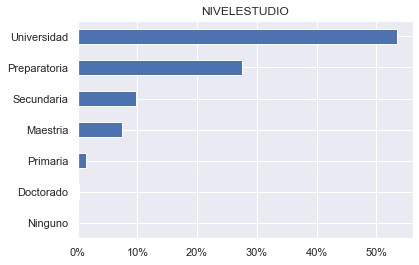

In [22]:
categorical_bar_plot('nivelEstudio')

La mayoria de los usuarios han finalizado la secundaría

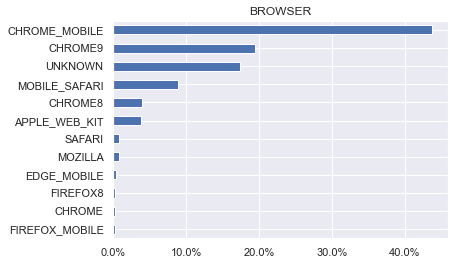

In [23]:
categorical_bar_plot('browser')

El grueso de los usuarios se conectan mediante dispositivos un dispositivo android

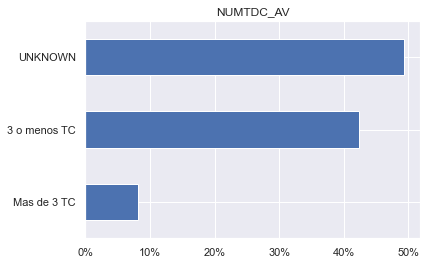

In [24]:
categorical_bar_plot('NUMTDC_AV')

No conocemos el nuemro de tarjetas de credito de casí el 50% de los usuarios

## Moroso Vs No moroso

Veamos como se comportan los datos de acuerdo a cada label

In [25]:
data_clean[data_clean['label']=='Moroso'].describe()

,edad,montoSolicitado,montoOtorgado,quincenal,dependientesEconomicos,fico,ingresosMensuales,gastosMensuales,emailScore
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,31.754545,17503.284000,11070.984409,0.150000,1.022727,516.363636,20749.836364,10696.136364,1.881818
std,9.119387,20078.066392,13527.928377,0.357886,1.140549,131.289372,21134.361626,12429.727442,3.024200
min,18.000000,1000.000000,1000.000000,0.000000,0.000000,0.000000,1000.000000,400.000000,0.000000
25%,25.000000,5875.000000,4000.000000,0.000000,0.000000,464.000000,10000.000000,4000.000000,0.000000
50%,30.000000,12000.000000,7000.000000,0.000000,1.000000,537.000000,15000.000000,6750.000000,1.000000
75%,36.000000,19072.500000,14021.000000,0.000000,2.000000,602.000000,25000.000000,13000.000000,1.000000
max,67.000000,150000.000000,100000.000000,1.000000,4.000000,710.000000,150000.000000,80000.000000,14.000000


In [26]:
data_clean[data_clean['label']=='No Moroso'].describe()

,edad,montoSolicitado,montoOtorgado,quincenal,dependientesEconomicos,fico,ingresosMensuales,gastosMensuales,emailScore
count,776.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000
mean,35.391753,15410.728538,12097.248590,0.157692,0.987179,538.471795,26010.237385,13255.520513,1.575641
std,10.321222,16158.668466,12783.504608,0.364686,1.124971,144.516752,41815.285113,31938.391897,5.445557
min,18.000000,1000.000000,1000.000000,0.000000,0.000000,0.000000,12.000000,2.000000,0.000000
25%,27.000000,5182.220000,4476.825000,0.000000,0.000000,497.000000,10000.000000,4500.000000,0.000000
50%,33.000000,11000.000000,8000.000000,0.000000,1.000000,568.000000,16000.000000,7500.000000,1.000000
75%,41.000000,19000.000000,15200.000000,0.000000,2.000000,622.000000,28000.000000,15000.000000,1.000000
max,69.000000,150000.000000,100000.000000,1.000000,5.000000,748.000000,900000.000000,750000.000000,80.000000


De las tablas anteriores se destaca que el 50% de los usuarios y en promedio de usuarios morosos
tienden a *pedir un monto* mayor respecto a los usuarios que no son morosos

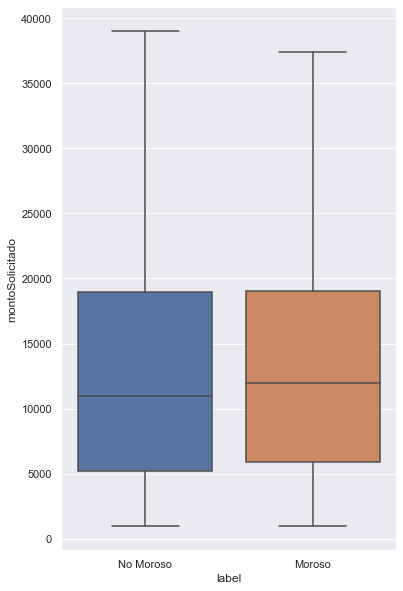

In [27]:
box_plot("montoSolicitado")

De igual manera destaca que los usuarios morosos en el segundo y tercer cuartil(50% y 75% de los usuarios) tienen un ingreso menor respecto a los No Morosos


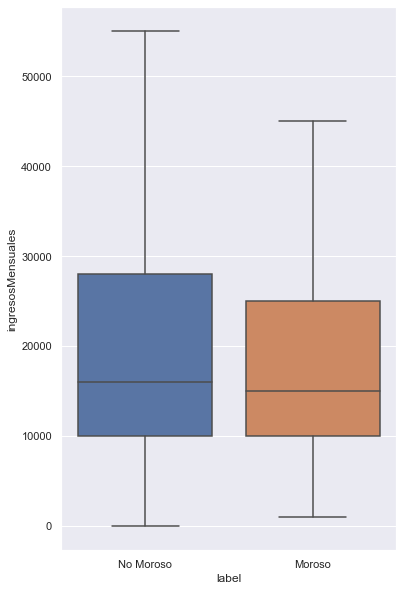

In [28]:
box_plot("ingresosMensuales")


Para el caso de gastosMensuales se debe de tener cierta precaucion ya que se observa que 
los usuarios morosos gastan menos, sin embargo es importante tomar en cuenta que al tener un 
ingreso menor es natural que sus gastos sean menores, por lo tanto encontraremos la proporción de gasto vs ingreso 

In [29]:
data_clean['Proporción de gasto'] = data_clean['gastosMensuales']/data_clean['ingresosMensuales']

data_clean.groupby('label')['Proporción de gasto'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Moroso,220.0,0.664243,1.288290,0.033333,0.349457,0.5,0.6,10.0
No Moroso,780.0,0.490723,0.314685,0.000360,0.347826,0.5,0.6,7.5


De lo anterior podemos destacar que los usuarios Morosos gastan en promedio un 0.664 de su ingreso, mayor al 0.49 de los usaurios No Morosos

Veamos la distribucion del nivel de estudios

e:\Documents\pruebas\atrato\venv\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


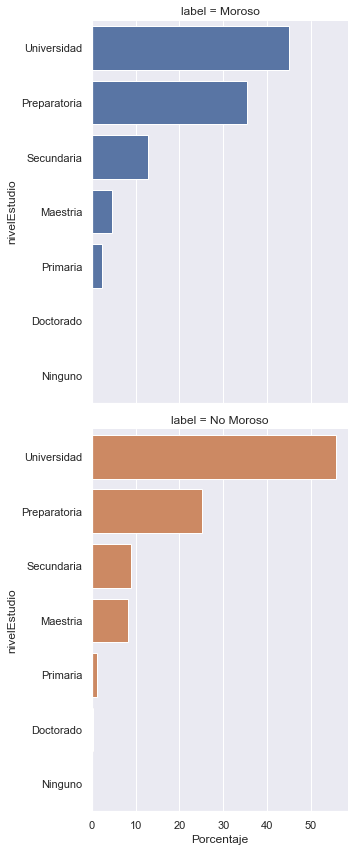

In [30]:
plot_ratio_by_column_and_label("nivelEstudio")

Lo usuarios No Morosos en su mayoria tinen la universidad

e:\Documents\pruebas\atrato\venv\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


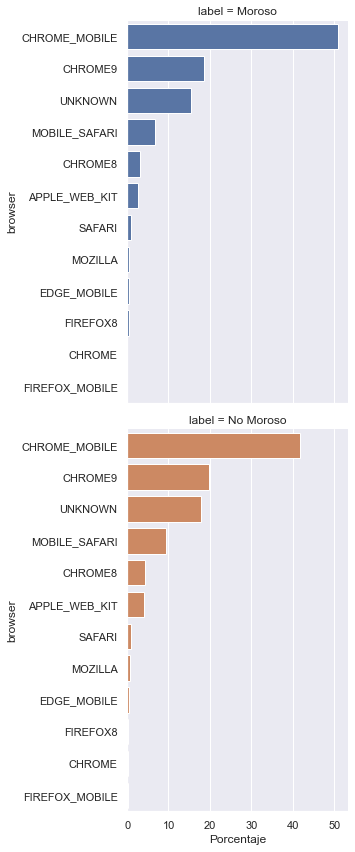

In [31]:
plot_ratio_by_column_and_label('browser')

Ambos tipos de usuarios tienen una distribucion similar, se puede destacar que los usuarios Morosos se conectan en su mayoria por CHROME_MOBILE

e:\Documents\pruebas\atrato\venv\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


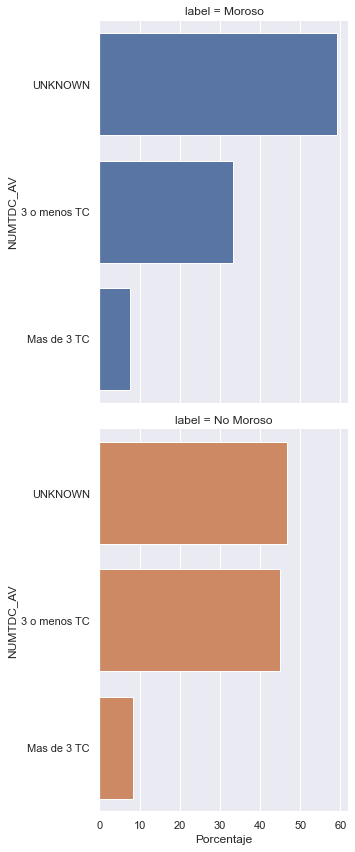

In [32]:
plot_ratio_by_column_and_label("NUMTDC_AV")

Genial ya tenemos ciertas caracteristicas generales de los datos ahora toca crear un modelo 

# Modelado

Al ser un modelo de clasificación binaria supervisada, en la literatura el primer modelo que se confronta a este tipo de problema, es la regresion logistica

Por lo anterior, la *Logistic regression* sera nuestro punto de partida para comparar con otros modelos y conocer si existe mejoria o no 
respecto a cada nuevo modelo

Al hablar de "mejoria" o "no mejoria" nos basaremos en "F1 score" ya que este es un problema de clasificacion 
desvalanceado https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

## Preprosesamiento

In [33]:
X = data_clean.drop(['label'], axis=1)
y = data_clean.label

# Split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=.3,random_state=100, stratify=y)

In [34]:
y_valid.value_counts()

No Moroso    234
Moroso        66
Name: label, dtype: int64

Nos apoyaremos de los pipeline de sklearn los cuales nos ayudan a simplicar mucho todo el proceso de entrenamiento

In [35]:
# Para el escalado de las variables numericas usaremos MinMaxScaler
# y como lo mensionamos anterirormente usaremos el promedio para la imputación
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

# handle_unknown='ignore' es importante en caso de tomar una categoria que no se encontraba 
# durante el proceso de entrenamiento
categorical_pipeline = Pipeline(steps=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# diferenciamos varibles numericas y las que no los son
numerical_features = X_train.select_dtypes(include=['number']).columns
categorical_features = X_train.select_dtypes(exclude=['number']).columns

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])


Con el pipeline anterior es más sencillo el preprosesamiento y nos enfocaremos en la selección del modelo

In [36]:
# Funciones auxiliares que nos ayudaran en el calculo y visualizacion de los distintos threshold

def get_f1_by_threshold(threshold, model_pipline):
    """Calcula el F1 para distintos threshold"""
    y_pred_pos = model_pipline.predict_proba(X_valid)[:,0] # probabilidades de pertenecer a la clase 1 
    y_pred_class = ["Moroso" if x > threshold else "No Moroso" for x in y_pred_pos  ]  

    return (f1_score(y_valid, y_pred_class, pos_label='Moroso'))


def threshold_f1_plot(model_pipeline, show_plot = True):
    """Grafica el f1 para cada threshold del modelo"""
    f1_values = [get_f1_by_threshold(threshold, model_pipeline) for threshold in np.linspace(0,1,500)]

    df = pd.DataFrame({
        'f1_values':f1_values, 
        'threshold': np.linspace(0,1,500)}
        )

    f1_value, threshold = df.sort_values('f1_values', ascending = False).iloc[0]

    if show_plot:
        
        plt.figure(figsize = (15, 5))
        plt.axvline(threshold, color='r', linestyle='--')
        plt.text(threshold+0.02, f1_value, f"f1_value : {round(f1_value, 3)} threshold : {round(threshold, 3)} ", horizontalalignment='left', size='medium', color='black', weight='semibold')
        sns.lineplot(x=df['threshold'], y=df['f1_values'])
        plt.show()

    return f1_value, threshold 

def correlation_matrix_plot(y_pred_pos, threshold):
    """ Grafica una matriz de coorrelacion para el mejor threshold del modelo"""
    y_pred_class = ["Moroso" if x > threshold else "No Moroso" for x in y_pred_pos  ]  
    cm = confusion_matrix(y_valid, y_pred_class)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="gist_yarg")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Moroso', 'No Moroso'])
    ax.yaxis.set_ticklabels(['Moroso', 'No Moroso'])
    plt.show()

    return y_pred_class

## Regresion Logistica

Este es nuestro primero modelo y sera nuestro *baseline* para hacer contraste en la mejora de cada nuevo modelo

In [37]:
logisticregression = LogisticRegression()

logisticregression_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', logisticregression)
])

_ = logisticregression_pipeline.fit(X_train, y_train)

Una vez ajustado el modelo un paso importante es encontrar el mejor 'threshold'
por lo tanto en busqueda de optimizar nuestro F1 score nos apoyaremos de distintos modelos y cada uno con distintos 'thresholds'

El threshold es algo importante al momento de clasificar ya que el movimiento de este valor provoca que aumenten o disminuyan las observaciones
que se clasifican en la clase positiva(morosos). Imaginemos que este umbral lo colocamos en .6 por lo tanto al ser evaluada una onservacion nos arroja como resultado 
.7 y al encontrarse por encima de dicho umbral(threshold) es calsficado cómo "Moroso", y por otra parte una nueva observacion obtiene un valor de 
.2 al encontrarse por debajo del umbral es clasificado cómo "No Moroso" al no poder superar el threshold establecido

de tal manera que por cada modelo identificaremos el threshold que nos de el F1 más alto, metrica seleccionada para es problema can caracteristicas de desvalance en las clases



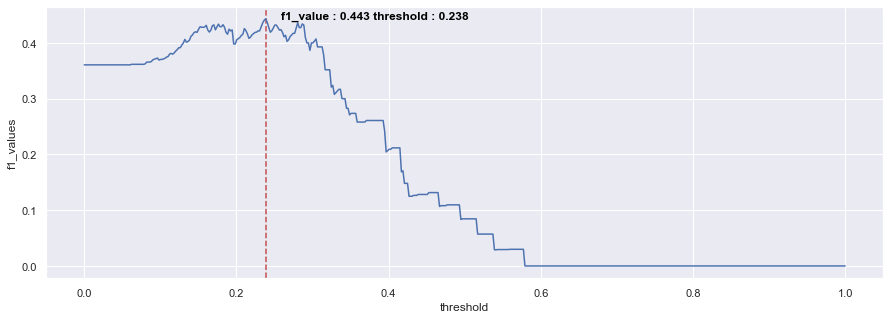

In [38]:
f1_value_logistic, threshold  = threshold_f1_plot(logisticregression_pipeline)

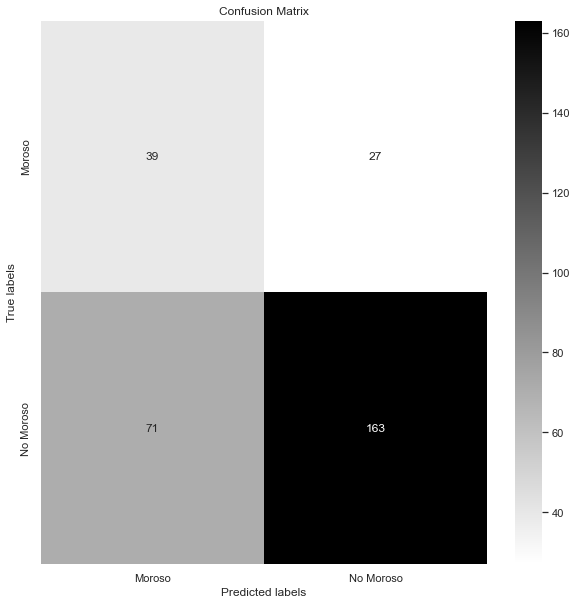

In [39]:
# al obtener el threshold con el mayor F1 procedemos a clasificar a cada usuario
y_pred_prob = logisticregression_pipeline.predict_proba(X_valid)[:,0] # probabilidades de pertenecer a la clase "Moroso"
y_pred_class_logisticregression = correlation_matrix_plot(y_pred_prob, threshold)

## linear SVM

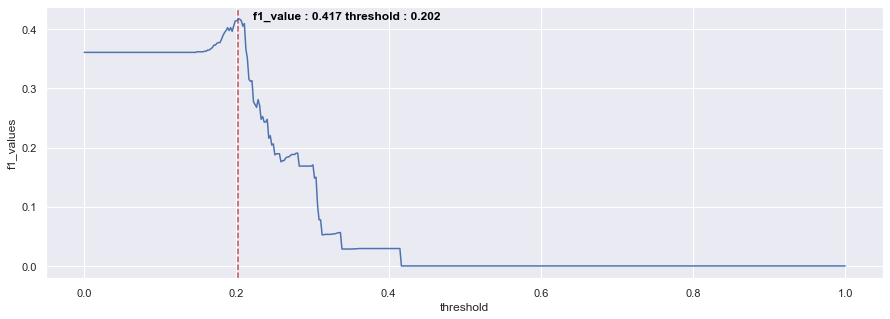

In [40]:
from sklearn.svm import SVC

svc = SVC(probability=True, random_state=3)

svc_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', svc)
])
 
svc_pipeline.fit(X_train, y_train)

f1_value_svm, threshold  = threshold_f1_plot(svc_pipeline)

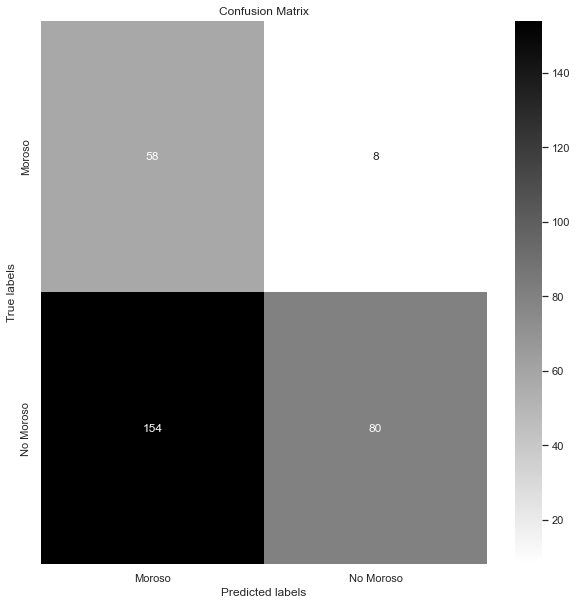

In [41]:
y_pred_prob = svc_pipeline.predict_proba(X_valid)[:,0] # probabilidades de pertenecer a la clase "Moroso"
y_pred_class_svc = correlation_matrix_plot(y_pred_prob, threshold)

## Naive bayes

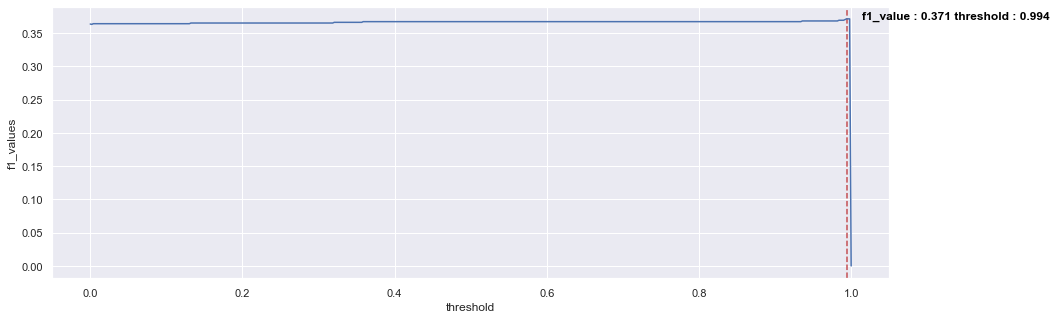

In [42]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

gnb_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', gnb)
])
 
gnb_pipeline.fit(X_train, y_train)

f1_value_gnb, threshold  = threshold_f1_plot(gnb_pipeline)

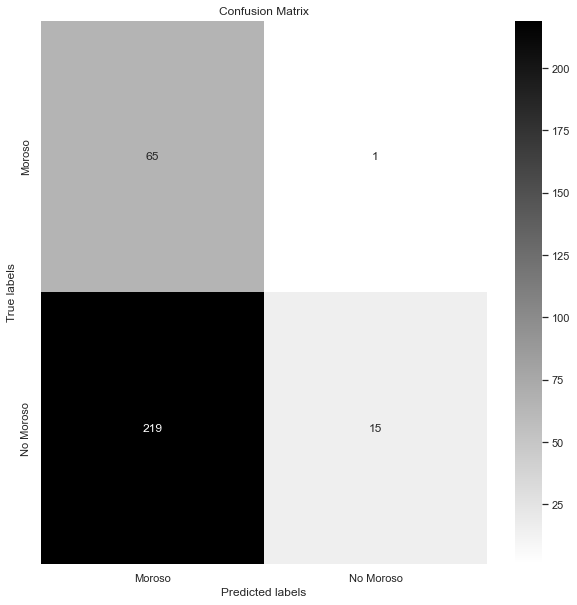

In [43]:
y_pred_prob = gnb_pipeline.predict_proba(X_valid)[:,0] # probabilidades de pertenecer a la clase 1
y_pred_class_gnb = correlation_matrix_plot(y_pred_prob, threshold)

## KNeighborsClassifier

Para el caso de knn el principal problema es la seccion correcta del valor de k nos limitaremos a solo seleccionar 3 valores de k
20, 30 y 40

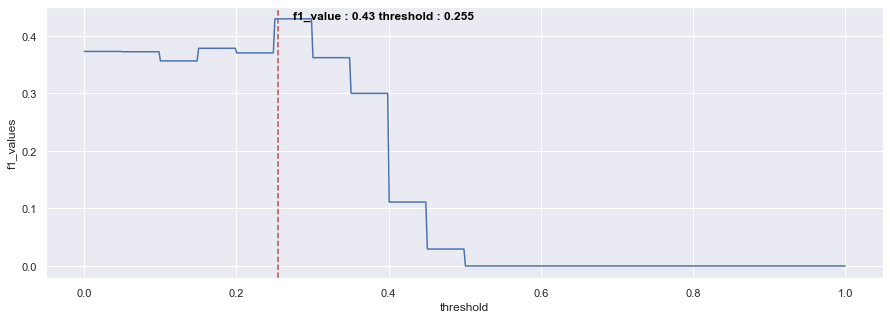

In [44]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=20)  

knn_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', knn)
])

_ = knn_pipeline.fit(X_train, y_train)

f1_value_knn20, threshold  = threshold_f1_plot(knn_pipeline)

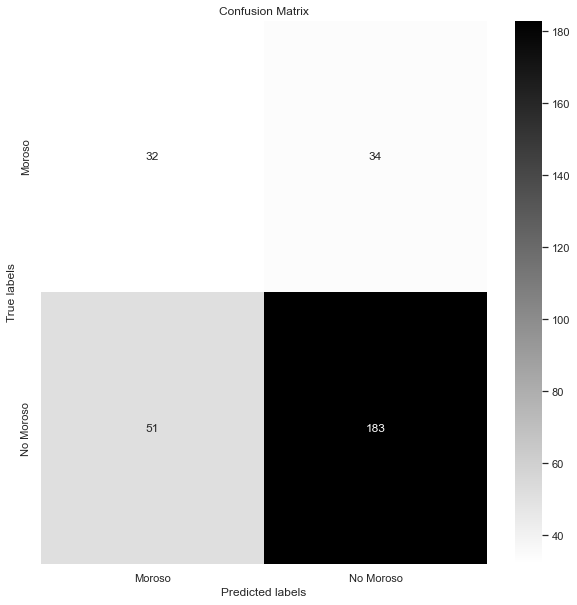

In [45]:
y_pred_prob = knn_pipeline.predict_proba(X_valid)[:,0] # probabilidades de pertenecer a la clase "Moroso"
y_pred_class_knn20 = correlation_matrix_plot(y_pred_prob, threshold)

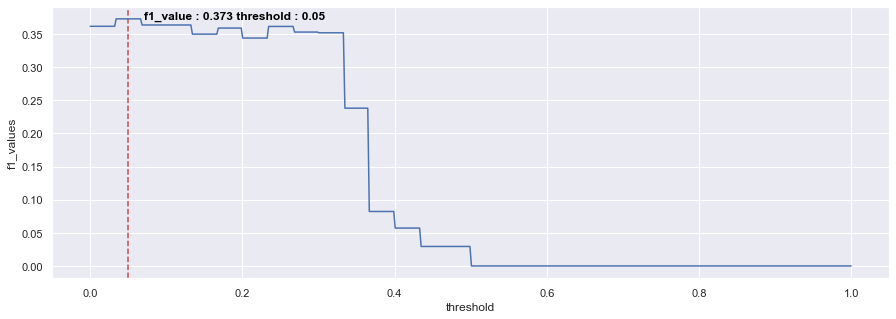

In [46]:
knn = KNeighborsClassifier(n_neighbors=30)  

knn_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', knn)
])

_ = knn_pipeline.fit(X_train, y_train)

f1_value_knn30, threshold  = threshold_f1_plot(knn_pipeline)

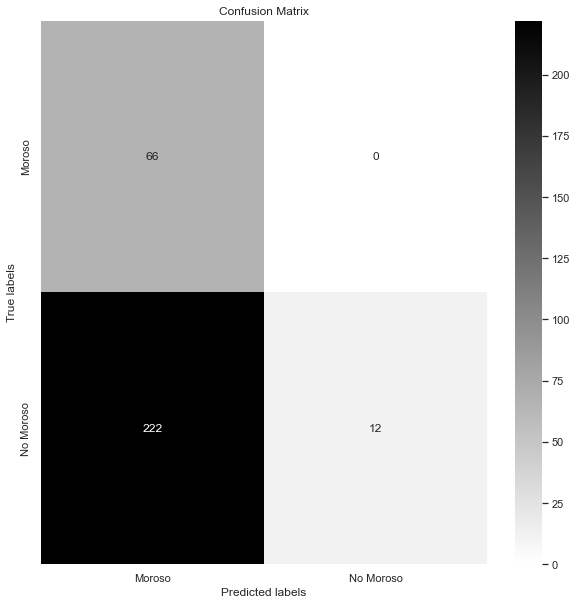

In [47]:
y_pred_prob = knn_pipeline.predict_proba(X_valid)[:,0] # probabilidades de pertenecer a la clase "Moroso"
y_pred_class_knn30 = correlation_matrix_plot(y_pred_prob, threshold)

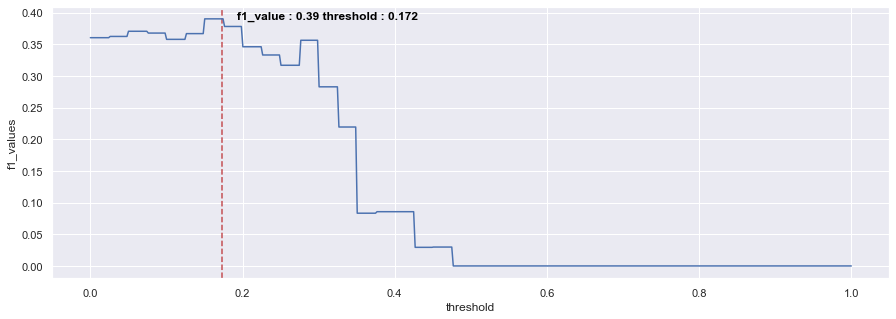

In [48]:
knn = KNeighborsClassifier(n_neighbors=40)  

knn_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', knn)
])

_ = knn_pipeline.fit(X_train, y_train)

f1_value_knn40, threshold  = threshold_f1_plot(knn_pipeline)

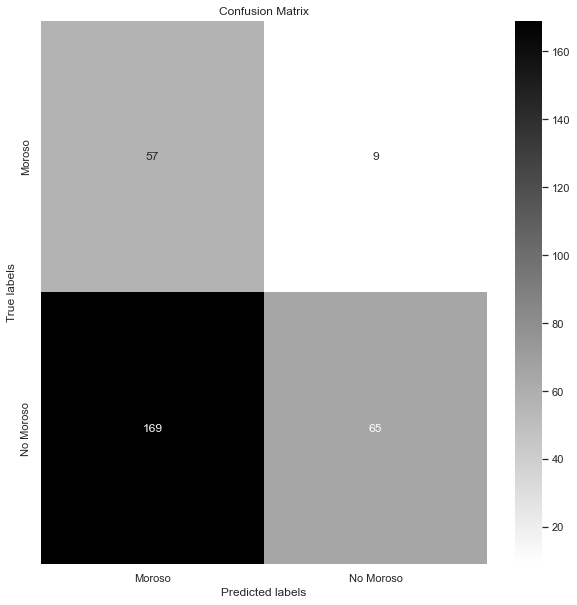

In [49]:
y_pred_prob = knn_pipeline.predict_proba(X_valid)[:,0] # probabilidades de pertenecer a la clase "Moroso"
y_pred_class_knn40 = correlation_matrix_plot(y_pred_prob, threshold)

de los 3 el mejor es con k = 20

## RandomForestClassifier

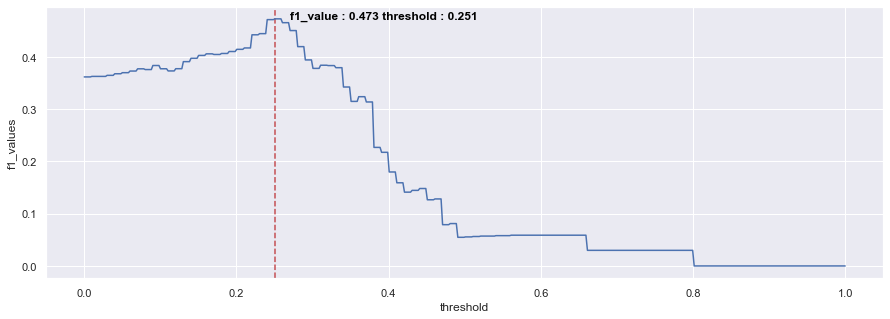

In [50]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=3)  


rf_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', rf)
])

rf_pipeline.fit(X_train, y_train)

f1_value_rf, threshold_rf  = threshold_f1_plot(rf_pipeline)


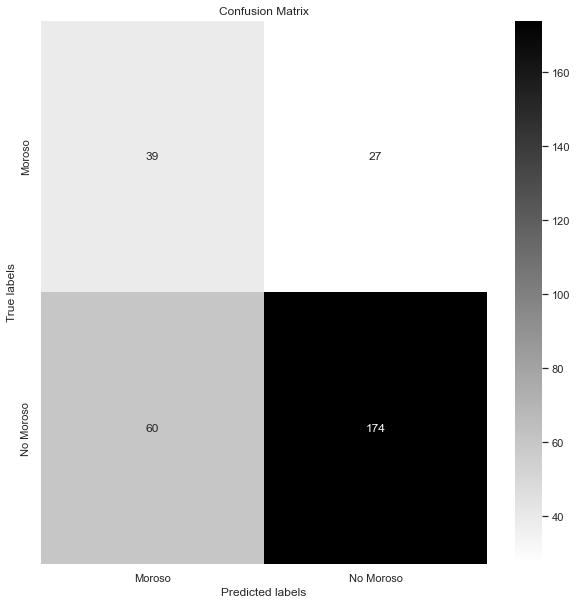

In [51]:
y_pred_prob_rf = rf_pipeline.predict_proba(X_valid)[:,0] # probabilidades de pertenecer a la clase "Moroso"
y_pred_class_rf = correlation_matrix_plot(y_pred_prob_rf, threshold_rf)

## lightgbm

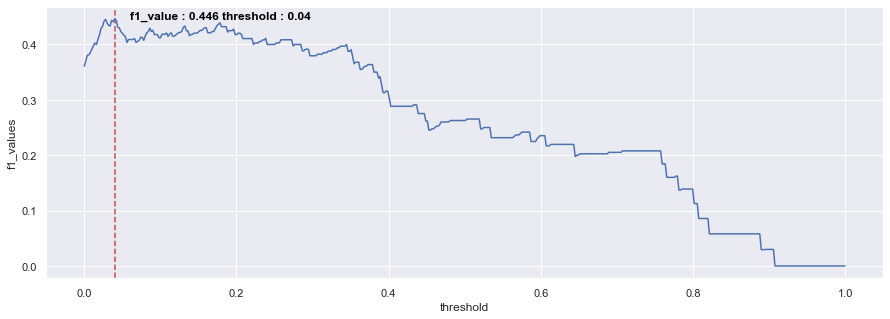

In [52]:
import lightgbm as lgb
lgbmc = lgb.LGBMClassifier()

lgbmc_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', lgbmc)
])

lgbmc_pipeline.fit(X_train, y_train)
f1_value_lgbm, threshold  = threshold_f1_plot(lgbmc_pipeline)

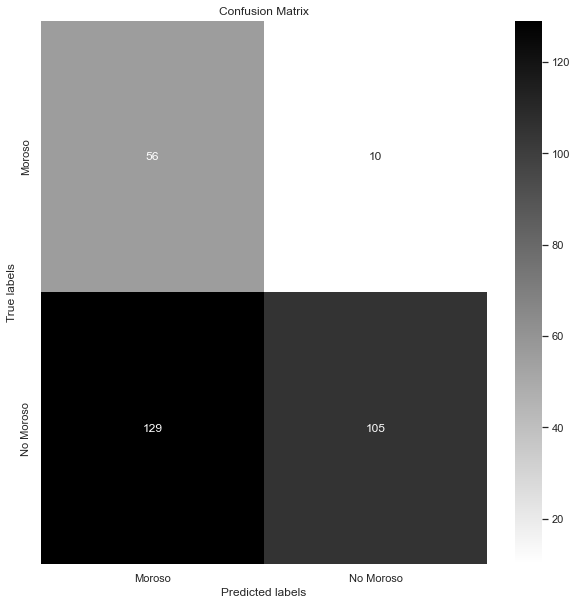

In [53]:
y_pred_prob = lgbmc_pipeline.predict_proba(X_valid)[:,0] # probabilidades de pertenecer a la clase "Moroso"
y_pred_class_lgbmc = correlation_matrix_plot(y_pred_prob, threshold)

## Comparacion de modelos

In [54]:
pd.DataFrame({
    "Model" : [
        "Logistic regression", 
        "SVM", 
        "Naive Bayes", 
        "knn20", 
        "knn30", 
        "kn40",
        "Random forest",
        "lightgbm"
        ],
    "F1 score": [
        f1_value_logistic, 
        f1_value_svm, 
        f1_value_gnb, 
        f1_value_knn20, 
        f1_value_knn30, 
        f1_value_knn40, 
        f1_value_rf, 
        f1_value_lgbm
        ]
     }).sort_values("F1 score", ascending = False)

,Model,F1 score
6,Random forest,0.472727
7,lightgbm,0.446215
0,Logistic regression,0.443182
3,knn20,0.429530
1,SVM,0.417266
5,kn40,0.390411
4,knn30,0.372881
2,Naive Bayes,0.371429


# Conclusiones 

Una vez explorados los modelos anteriores y sin hacer una optimizacion de parametros tienden a comportarse de manera muy similar
sin embargo el modelo seleccionado es el de Random Forest ya que mostro un mayor F1 score por lo tanto este es el modelo seleccionado 
y usado en producción


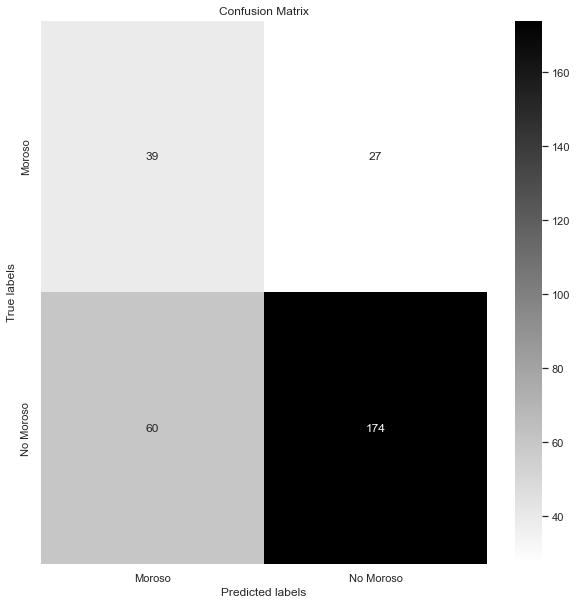

In [55]:
y_pred_class_rf = correlation_matrix_plot(y_pred_prob_rf, threshold_rf)

Con la grafica anterior vemos que para el modelo seleccionado tiene cómo su principal fortaleze la deteción de usuarios No Morosos(verdaderos negativos), por otra parte un accionable a utilizar para reducir los falsos positivos (usuarios clasificados cómo morosos y no ser el caso) es, por cada vez que un usuario sea clasificado "Moroso" contara con una cantidad menor de plazos para el periodo de pago, una tasa mayor de interes y sí en un perido de al menos 3 meses o haber liquidado su primer monto solicitado, sera candidato a ser clasificado cómo No Moroso, lo anterior con la finalidad de minimizar el riezgo.


Este jupyternotebook es una parte del proyecto que se encuentra aquí https://github.com/alonmar/users_classification_default

In [56]:
# Guardamos el f1 actual del modelo así como el mejor threshold para ser usado en producción

joblib.dump(rf_pipeline, gzip.open('model/model_binary_class.dat.gz', "wb"))

rf_pipeline.fit(X_train, y_train)

f1_value, threshold  = threshold_f1_plot(rf_pipeline, show_plot = False)

data = {
    'f1_value' : f1_value,
    'threshold' : threshold,
        }

with open('model/model_outputs.json', 'w') as outfile:
    json.dump(data, outfile, indent=4)

# Next Steps

Con la estructura actual es posible iterarar de forma sencilla con distintos modelos y disitintos hyperparametros y con el apoyo de MlOps y herramientas cómo
DVC (https://dvc.org/doc) para un versionado de modelos entrenados.

Con la columna "browser" identificar a los usuarios que se conectan mediante un dispositivo movíl y observar sí esite mejoras en la metrica.

Algo que es interesante es seleccionar al menos a los 3 mejores modelos y que voten a que clase deberia de ser asignado cada usuario y gracias a la función *VotingClassifier()* de *sklearn* este proceso es más sencillo.

Random forest es un buen modelo para comenzar a hacer *RandomizedSearchCV* y observar sí existe mejoría en la clasificación

# Predicción para Test Data

Ahora toca hacer la predicción de los 'Test Data'

In [59]:
# Cargamos los datos
test_data = pd.read_csv('raw_data/Test Data.csv')
# Limpiamos
test_data_clean = clean_data(test_data)
# No necesitamos para la clasificación la columna ID
ids = test_data_clean.pop('ID')
test_data_clean.head()



,edad,montoSolicitado,montoOtorgado,genero,quincenal,dependientesEconomicos,nivelEstudio,fico,ingresosMensuales,gastosMensuales,emailScore,browser,NUMTDC_AV
0,30.0,20000.0,40000.0,Hombre,1,0,Universidad,575,25000.0,15000,1.0,UNKNOWN,3 o menos TC
1,31.0,2000.0,2000.0,Hombre,0,4,Preparatoria,635,12000.0,8000,8.0,CHROME9,UNKNOWN
2,29.0,15000.0,15000.0,Mujer,0,0,Universidad,568,20000.0,14000,0.0,CHROME_MOBILE,3 o menos TC
3,20.0,7000.0,6000.0,Mujer,0,1,Universidad,643,2000.0,6000,1.0,CHROME_MOBILE,UNKNOWN
4,34.0,18000.0,12999.0,Hombre,1,1,Universidad,546,50000.0,30000,0.0,APPLE_WEB_KIT,3 o menos TC


In [60]:
# creamos la columna Proporción de gasto
test_data_clean['Proporción de gasto'] = test_data_clean['gastosMensuales']/test_data_clean['ingresosMensuales']

# Hacemos la predicción
y_pred_pos = rf_pipeline.predict_proba(test_data_clean)[:,0] # probabilidades de pertenecer a la clase "Moroso"
y_pred_class = y_pred_pos > threshold_rf
y_pred_class

result = pd.DataFrame({'ids':ids, 'label':y_pred_class.astype(int)})

result.to_csv('result/test_data_classification.csv', index=False)

result

,ids,label
0,1,0
1,2,0
2,3,0
3,4,1
4,5,0
...,...,...
295,296,1
296,297,1
297,298,1
298,299,0
